In [9]:
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
import sys

# Add the src folder to sys.path
sys.path.append(str(Path().resolve().parent / "src"))

from music_recommender.config import Config
from sklearn.base import clone

from typing import Tuple, Dict, Any, Union, List
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR, SVC
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    explained_variance_score,
    mean_absolute_percentage_error,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    roc_auc_score,
)
from tqdm import tqdm
import pickle
import hashlib
import io
import joblib


from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.feature_selection import (
    SelectKBest,
    mutual_info_regression,
    VarianceThreshold,
)

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from skopt.space import Real, Integer, Categorical


from skopt import BayesSearchCV

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [10]:
root = Path()

In [12]:
cfg = Config()
asp = cfg.paths.audio_spotify
prc = cfg.paths.processed
intr = cfg.paths.interim

print(asp, prc, intr)

\\wsl.localhost\Ubuntu-22.04\home\rime\music-recom\data\processed\audio \\wsl.localhost\Ubuntu-22.04\home\rime\music-recom\data\processed \\wsl.localhost\Ubuntu-22.04\home\rime\music-recom\data\interim


In [3]:
import hashlib
import pickle
from pathlib import Path
from typing import Union, Dict, Any, Optional
import numpy as np
import librosa
import io
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin


class AudioLoader(BaseEstimator, TransformerMixin):
    """Load audio files from paths or bytes with caching support"""
    
    def __init__(
        self, 
        sr: int = 22050,
        use_cache: bool = True,
        cache_dir: Optional[Union[str, Path]] = None,
        max_cache_size_mb: int = 1000
    ):
        """
        Parameters
        ----------
        sr : int
            Target sampling rate
        use_cache : bool
            Whether to use caching (default: True)
        cache_dir : str or Path, optional
            Directory for cache files. If None, uses './audio_cache'
        max_cache_size_mb : int
            Maximum cache size in MB. Old entries removed when exceeded.
        """
        self.sr = sr
        self.use_cache = use_cache
        self.cache_dir = Path(cache_dir) if cache_dir else Path('./audio_cache')
        self.max_cache_size_mb = max_cache_size_mb
        
        # In-memory cache for current session
        self._memory_cache = {}
        
        # Setup cache directory
        if self.use_cache:
            self.cache_dir.mkdir(parents=True, exist_ok=True)
            self._cache_index_path = self.cache_dir / "cache_index.pkl"
            self._load_cache_index()
    
    def _load_cache_index(self):
        """Load cache index (tracks what's cached and access times)"""
        if self._cache_index_path.exists():
            try:
                with open(self._cache_index_path, 'rb') as f:
                    self._cache_index = pickle.load(f)
            except Exception:
                self._cache_index = {}
        else:
            self._cache_index = {}
    
    def _save_cache_index(self):
        """Save cache index to disk"""
        try:
            with open(self._cache_index_path, 'wb') as f:
                pickle.dump(self._cache_index, f)
        except Exception as e:
            print(f"Warning: Could not save cache index: {e}")
    
    def _get_cache_key(self, item: Union[str, Path, bytes]) -> str:
        """Generate unique cache key for an item"""
        if isinstance(item, (str, Path)):
            # For files: use path + modification time + sr
            path = Path(item)
            if path.exists():
                mtime = path.stat().st_mtime
                key_string = f"{path.absolute()}_{mtime}_{self.sr}"
            else:
                key_string = f"{path.absolute()}_{self.sr}"
        elif isinstance(item, bytes):
            # For bytes: use hash of content + sr
            content_hash = hashlib.md5(item).hexdigest()
            key_string = f"bytes_{content_hash}_{self.sr}"
        else:
            raise ValueError(f"Unsupported input type: {type(item)}")
        
        # Return hash of key_string
        return hashlib.sha256(key_string.encode()).hexdigest()
    
    def _get_from_cache(self, cache_key: str) -> Optional[Dict[str, Any]]:
        """Retrieve item from cache (memory or disk)"""
        # Check memory cache first (fastest)
        if cache_key in self._memory_cache:
            return self._memory_cache[cache_key]
        
        # Check disk cache
        cache_file = self.cache_dir / f"{cache_key}.pkl"
        if cache_file.exists():
            try:
                with open(cache_file, 'rb') as f:
                    data = pickle.load(f)
                
                # Update memory cache
                self._memory_cache[cache_key] = data
                
                # Update access time in index
                if cache_key in self._cache_index:
                    self._cache_index[cache_key]['last_access'] = np.datetime64('now')
                
                return data
            except Exception as e:
                print(f"Warning: Could not load cache file {cache_file}: {e}")
                return None
        
        return None
    
    def _save_to_cache(self, cache_key: str, data: Dict[str, Any]):
        """Save item to cache (memory and disk)"""
        # Save to memory cache
        self._memory_cache[cache_key] = data
        
        # Save to disk cache
        cache_file = self.cache_dir / f"{cache_key}.pkl"
        try:
            with open(cache_file, 'wb') as f:
                pickle.dump(data, f)
            
            # Update cache index
            file_size = cache_file.stat().st_size / (1024 * 1024)  # MB
            self._cache_index[cache_key] = {
                'file': cache_file,
                'size_mb': file_size,
                'last_access': np.datetime64('now'),
                'created': np.datetime64('now')
            }
            
            # Check cache size and cleanup if needed
            self._cleanup_cache_if_needed()
            
        except Exception as e:
            print(f"Warning: Could not save to cache: {e}")
    
    def _cleanup_cache_if_needed(self):
        """Remove old cache entries if cache size exceeds limit"""
        total_size = sum(info['size_mb'] for info in self._cache_index.values())
        
        if total_size > self.max_cache_size_mb:
            # Sort by last access time (oldest first)
            sorted_entries = sorted(
                self._cache_index.items(),
                key=lambda x: x[1]['last_access']
            )
            
            # Remove oldest entries until under limit
            for cache_key, info in sorted_entries:
                if total_size <= self.max_cache_size_mb * 0.9:  # 90% of limit
                    break
                
                try:
                    # Remove file
                    if info['file'].exists():
                        info['file'].unlink()
                    
                    # Remove from index
                    total_size -= info['size_mb']
                    del self._cache_index[cache_key]
                    
                    # Remove from memory cache
                    if cache_key in self._memory_cache:
                        del self._memory_cache[cache_key]
                        
                except Exception as e:
                    print(f"Warning: Could not remove cache file: {e}")
            
            # Save updated index
            self._save_cache_index()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X) -> np.ndarray:
        """
        Transform paths/bytes to audio data
        
        Parameters
        ----------
        X : str, Path, bytes, or list of these
            Audio file paths or raw audio bytes
        
        Returns
        -------
        np.ndarray
            Array of dictionaries containing audio data
        """
        # Normalize input
        if isinstance(X, (str, Path, bytes)):
            X = [X]
        elif hasattr(X, "tolist"):
            X = X.tolist()
        
        results = []
        cache_hits = 0
        cache_misses = 0
        
        for item in tqdm(X, desc="Loading audio"):
            if self.use_cache:
                cache_key = self._get_cache_key(item)
                cached_data = self._get_from_cache(cache_key)
                
                if cached_data is not None:
                    results.append(cached_data)
                    cache_hits += 1
                    continue
            
            # Load from source
            loaded = self._load_single(item)
            results.append(loaded)
            cache_misses += 1
            
            # Save to cache
            if self.use_cache:
                self._save_to_cache(cache_key, loaded)
        
        # Print cache statistics
        if self.use_cache and (cache_hits + cache_misses) > 0:
            hit_rate = cache_hits / (cache_hits + cache_misses) * 100
            print(f"Cache: {cache_hits} hits, {cache_misses} misses ({hit_rate:.1f}% hit rate)")
        
        return np.array(results, dtype=object)
    
    def _load_single(self, item: Union[str, Path, bytes]) -> Dict[str, Any]:
        """Load a single audio file"""
        if isinstance(item, (str, Path)):
            # Load from file path
            audio, sr = librosa.load(item, sr=self.sr)
            return {
                "audio": audio,
                "sr": sr,
                "path": Path(item),
                "source_type": "path"
            }
        
        elif isinstance(item, bytes):
            # Load from bytes
            audio, sr = librosa.load(io.BytesIO(item), sr=self.sr)
            audio_hash = hashlib.md5(item[:10000]).hexdigest()
            pseudo_path = Path(f"uploaded_{audio_hash}")
            
            return {
                "audio": audio,
                "sr": sr,
                "path": pseudo_path,
                "source_type": "bytes"
            }
        
        else:
            raise ValueError(f"Unsupported input type: {type(item)}")
    
    def clear_cache(self, older_than_days: Optional[int] = None):
        """
        Clear cache files
        
        Parameters
        ----------
        older_than_days : int, optional
            If specified, only clear cache entries older than this many days.
            If None, clears entire cache.
        """
        if not self.use_cache:
            return
        
        if older_than_days is None:
            # Clear everything
            for cache_file in self.cache_dir.glob("*.pkl"):
                try:
                    cache_file.unlink()
                except Exception:
                    pass
            self._cache_index = {}
            self._memory_cache = {}
            print(f"Cleared all cache from {self.cache_dir}")
        else:
            # Clear old entries
            cutoff = np.datetime64('now') - np.timedelta64(older_than_days, 'D')
            removed_count = 0
            
            for cache_key, info in list(self._cache_index.items()):
                if info['last_access'] < cutoff:
                    try:
                        if info['file'].exists():
                            info['file'].unlink()
                        del self._cache_index[cache_key]
                        if cache_key in self._memory_cache:
                            del self._memory_cache[cache_key]
                        removed_count += 1
                    except Exception:
                        pass
            
            print(f"Removed {removed_count} cache entries older than {older_than_days} days")
        
        self._save_cache_index()
    
    def get_cache_stats(self) -> Dict[str, Any]:
        """Get cache statistics"""
        if not self.use_cache:
            return {"cache_enabled": False}
        
        total_size = sum(info['size_mb'] for info in self._cache_index.values())
        
        return {
            "cache_enabled": True,
            "cache_dir": str(self.cache_dir),
            "num_cached_items": len(self._cache_index),
            "total_size_mb": round(total_size, 2),
            "max_size_mb": self.max_cache_size_mb,
            "utilization_pct": round(total_size / self.max_cache_size_mb * 100, 1),
            "memory_cache_items": len(self._memory_cache)
        }

In [4]:
class MFCCExtractor(BaseEstimator, TransformerMixin):
    """Extract MFCC features with statistics (mean, std, quartiles)"""

    def __init__(self,
                 sr: int = 22050,
                 n_mfcc: int = 13,
                 n_fft: int = 2048,
                 hop_length: int = 512,
                 cache_dir: Path = None, 
                 enable_cache: bool = True
                 ):
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.cache_dir = cache_dir
        self.enable_cache = enable_cache

        if enable_cache and cache_dir:
            cache_dir.mkdir(parents=True, exist_ok = True)

    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X) -> pd.DataFrame:
        """
        Extract mfcc features from audio data
        X: array of dicts from AudioLoader
        """
        feature_vectors = []

        for audio_dict in tqdm(X, desc='Extracting MFCC features'):
            audio = audio_dict["audio"]
            audio_path = audio_dict["path"]
            source_type = audio_dict["source_type"]

            # Try cache
            if self.enable_cache and source_type == "path":
                cache_key = self._get_cache_key(audio_path)
                cached = self._load_from_cache(cache_key)
                if cached is not None:
                    feature_vectors.append(cached)
                    continue

            # Extract features 
            features = self._extract_mfcc_stats(audio)

            # Save to cache
            if self.enable_cache and source_type=="path":
                cache_key = self._get_cache_key(audio_path)
                self._save_to_cache(cache_key, features)

            feature_vectors.append(features)

        return pd.DataFrame(feature_vectors)
    

    def _extract_mfcc_stats(self, audio: np.ndarray) -> Dict[str, float]:
        """Extract MFCC and compute statistics"""
        # Compute MFCCs
        mfccs = librosa.feature.mfcc(
            y=audio,
            sr=self.sr,
            n_mfcc=self.n_mfcc,
            n_fft=self.n_fft,
            hop_length=self.hop_length
        )
        
        # Compute deltas
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        
        # Compute statistics
        stats = {}
        
        # MFCC statistics
        for i in range(self.n_mfcc):
            stats.update(self._make_stats(mfccs[i, :], f"mfcc_{i}"))
        
        # Delta statistics
        for i in range(self.n_mfcc):
            stats.update(self._make_stats(delta_mfccs[i, :], f"delta_{i}"))
        
        # Delta2 statistics
        for i in range(self.n_mfcc):
            stats.update(self._make_stats(delta2_mfccs[i, :], f"delta2_{i}"))
        
        return stats
    
    @staticmethod
    def _make_stats(feature_array: np.ndarray, name: str) -> Dict[str, float]:
        """Compute statistics for a feature array"""
        return {
            f"{name}_mean": float(np.mean(feature_array)),
            f"{name}_std": float(np.std(feature_array)),
            f"{name}_min": float(np.min(feature_array)),
            f"{name}_max": float(np.max(feature_array)),
            f"{name}_median": float(np.median(feature_array)),
            f"{name}_q25": float(np.percentile(feature_array, 25)),
            f"{name}_q75": float(np.percentile(feature_array, 75))
        }
    
    def _get_cache_key(self, audio_path: Path) -> str:
        """Generate cache key"""
        params = f"{audio_path}_{self.sr}_{self.n_mfcc}_{self.n_fft}_{self.hop_length}"
        return hashlib.md5(params.encode()).hexdigest()
    
    def _load_from_cache(self, cache_key: str) -> Dict[str, float]:
        """Load from cache"""
        if not self.cache_dir:
            return None
        
        cache_file = self.cache_dir / f"{cache_key}.pkl"
        if cache_file.exists():
            try:
                with open(cache_file, 'rb') as f:
                    return pickle.load(f)
            except Exception:
                return None
        return None
    
    def _save_to_cache(self, cache_key: str, features: Dict[str, float]):
        """Save to cache"""
        if not self.cache_dir:
            return
        
        cache_file = self.cache_dir / f"{cache_key}.pkl"
        try:
            with open(cache_file, 'wb') as f:
                pickle.dump(features, f)
        except Exception:
            pass

In [5]:
class UnifiedMusicPredictor:
    """Train multiple models for grouped regression and classification targets"""
    
    def __init__(
        self,
        target_groups: Dict[str, Dict[str, List[str]]],
        model_configs: Dict[str, Dict[str, Dict]],
        n_iter_config: Dict[str, int],
        use_scaler: bool = True
    ):
        self.target_groups = target_groups
        self.model_configs = model_configs
        self.n_iter_config = n_iter_config
        self.use_scaler = use_scaler
        self.scaler = StandardScaler() if use_scaler else None
        
        # Store trained models: {task_type: {group_name: {model_name: model}}}
        self.trained_models = {'regression': {}, 'classification': {}}
        self.best_models = {'regression': {}, 'classification': {}}  # Best model per group
        self.training_results = {'regression': {}, 'classification': {}}
    
    def fit(self, X: pd.DataFrame, y: pd.DataFrame, cv: int = 4, n_jobs: int = -1):
        """Train all models for all groups"""
        # Scale features
        if self.use_scaler:
            X_scaled = pd.DataFrame(
                self.scaler.fit_transform(X),
                columns=X.columns,
                index=X.index
            )
        else:
            X_scaled = X
        
        # Train regression models
        if 'regression' in self.target_groups:
            self._fit_task(
                X_scaled, y, 
                task_type='regression',
                cv=cv,
                n_jobs=n_jobs
            )
        
        # Train classification models
        if 'classification' in self.target_groups:
            self._fit_task(
                X_scaled, y,
                task_type='classification',
                cv=cv,
                n_jobs=n_jobs
            )
    
    def _fit_task(
        self,
        X: pd.DataFrame,
        y: pd.DataFrame,
        task_type: str,
        cv: int,
        n_jobs: int
    ):
        """Train all models for a specific task type (regression/classification)"""
        
        print(f"\nTRAINING {task_type.upper()} MODELS")
        
        groups = self.target_groups[task_type]
        models = self.model_configs[task_type]
        
        for group_name, target_cols in groups.items():
            print(f"Group: {group_name.upper()} | Targets: {target_cols}")
            
            y_group = y[target_cols]
            self.trained_models[task_type][group_name] = {}
            self.training_results[task_type][group_name] = {}
            
            best_score = -np.inf
            best_model_name = None
            
            for model_name, config in models.items():
                print(f"\nTraining {model_name}...")
                
                try:
                    # Wrap in MultiOutput if multiple targets
                    if len(target_cols) > 1:
                        if task_type == 'regression':
                            base = MultiOutputRegressor(clone(config['base_model']))
                        else:
                            base = MultiOutputClassifier(clone(config['base_model']))
                        # Keep estimator__ prefix for MultiOutput wrappers
                        param_grid = config['param_grid']
                    else:
                        # For single output, use base model directly
                        base = clone(config['base_model'])
                        # Remove 'estimator__' prefix for single-output models
                        param_grid = {
                            key.replace('estimator__', ''): value 
                            for key, value in config['param_grid'].items()
                        }
                    
                    # Setup BayesSearchCV
                    n_iter = self.n_iter_config.get(model_name, 30)
                    scoring = 'r2' if task_type == 'regression' else 'balanced_accuracy'
                    
                    search = BayesSearchCV(
                        estimator=base,
                        search_spaces=param_grid,
                        n_iter=n_iter,
                        cv=cv,
                        scoring=scoring,
                        n_jobs=n_jobs,
                        random_state=42,
                        verbose=0
                    )
                    
                    search.fit(X, y_group.values.ravel() if len(target_cols) == 1 else y_group)
                    
                    # Store model
                    self.trained_models[task_type][group_name][model_name] = search.best_estimator_
                    
                    # Store results
                    self.training_results[task_type][group_name][model_name] = {
                        'best_score': search.best_score_,
                        'best_params': search.best_params_,
                        'cv_results': search.cv_results_
                    }
                    
                    print(f"  ✓ {model_name}: {scoring}={search.best_score_:.4f}")
                    print(f"    Best params: {search.best_params_}")
                    
                    # Track best model
                    if search.best_score_ > best_score:
                        best_score = search.best_score_
                        best_model_name = model_name
                
                except Exception as e:
                    print(f"  ✗ {model_name} failed: {str(e)}")
            
            # Set best model for this group
            if best_model_name:
                self.best_models[task_type][group_name] = {
                    'model_name': best_model_name,
                    'model': self.trained_models[task_type][group_name][best_model_name],
                    'targets': target_cols,
                    'score': best_score
                }
                print(f"\n  Best model for {group_name}: {best_model_name} ({best_score:.4f})")
    
    def predict(
        self,
        X: pd.DataFrame,
        use_best: bool = True,
        specific_models: Dict[str, Dict[str, str]] = None
    ) -> Dict[str, np.ndarray]:
        """
        Predict using trained models
        """
        if self.use_scaler:
            X_scaled = pd.DataFrame(
                self.scaler.transform(X),
                columns=X.columns,
                index=X.index
            )
        else:
            X_scaled = X
        
        predictions = {}
        
        for task_type in ['regression', 'classification']:
            if task_type not in self.target_groups:
                continue
            
            for group_name in self.target_groups[task_type].keys():
                # Select model
                if use_best:
                    if group_name not in self.best_models[task_type]:
                        continue
                    model = self.best_models[task_type][group_name]['model']
                    targets = self.best_models[task_type][group_name]['targets']
                else:
                    model_name = specific_models[task_type][group_name]
                    model = self.trained_models[task_type][group_name][model_name]
                    targets = self.target_groups[task_type][group_name]
                
                # Predict
                pred = model.predict(X_scaled)
                
                # Store predictions
                if len(targets) == 1:
                    predictions[targets[0]] = pred
                else:
                    for i, target in enumerate(targets):
                        predictions[target] = pred[:, i]
        
        return predictions
    
    def evaluate(
        self,
        X: pd.DataFrame,
        y: pd.DataFrame,
        use_best: bool = True
    ) -> Dict[str, Dict[str, Dict]]:
        """Evaluate all models"""
        predictions = self.predict(X, use_best=use_best)
        results = {'regression': {}, 'classification': {}}
        
        # Evaluate regression
        if 'regression' in self.target_groups:
            for group_name, targets in self.target_groups['regression'].items():
                results['regression'][group_name] = {}
                for target in targets:
                    if target in predictions:
                        y_true = y[target].values
                        y_pred = predictions[target]
                        results['regression'][group_name][target] = {
                            'r2': r2_score(y_true, y_pred),
                            'mae': mean_absolute_error(y_true, y_pred),
                            'rmse': np.sqrt(mean_squared_error(y_true, y_pred))
                        }
        
        # Evaluate classification
        if 'classification' in self.target_groups:
            for group_name, targets in self.target_groups['classification'].items():
                results['classification'][group_name] = {}
                for target in targets:
                    if target in predictions:
                        y_true = y[target].values
                        y_pred = predictions[target]
                        results['classification'][group_name][target] = {
                            'accuracy': accuracy_score(y_true, y_pred),
                            'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
                            'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
                        }
        
        return results
    
    def save_models(self, save_dir: Path):
        """Save all models and metadata"""
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        
        # Save scaler
        if self.use_scaler and self.scaler is not None:
            joblib.dump(self.scaler, save_dir / "scaler.pkl")
            print("✓ Saved scaler")
        
        # Save best models
        for task_type in ['regression', 'classification']:
            for group_name, info in self.best_models[task_type].items():
                path = save_dir / f"{task_type}_{group_name}_best.pkl"
                joblib.dump(info, path)
                print(f"✓ Saved {task_type}/{group_name}: {info['model_name']}")
        
        # Save metadata
        metadata = {
            'target_groups': self.target_groups,
            'best_models': {
                task: {
                    group: {'model_name': info['model_name'], 'score': info['score']}
                    for group, info in groups.items()
                }
                for task, groups in self.best_models.items()
            }
        }
        joblib.dump(metadata, save_dir / "metadata.pkl")
        print("✓ Saved metadata")
    
    def load_models(self, load_dir: Path):
        """Load saved models"""
        load_dir = Path(load_dir)
        
        # Load scaler
        if self.use_scaler:
            scaler_path = load_dir / "scaler.pkl"
            if scaler_path.exists():
                self.scaler = joblib.load(scaler_path)
                print("✓ Loaded scaler")
        
        # Load metadata
        metadata = joblib.load(load_dir / "metadata.pkl")
        
        # Load best models
        for task_type in ['regression', 'classification']:
            for group_name in metadata['target_groups'][task_type].keys():
                path = load_dir / f"{task_type}_{group_name}_best.pkl"
                if path.exists():
                    self.best_models[task_type][group_name] = joblib.load(path)
                    print(f"✓ Loaded {task_type}/{group_name}")


    def get_results_dataframe(self, eval_results: Dict[str, Dict[str, Dict]]) -> pd.DataFrame:
        """
        Create a DataFrame with model name, target group, feature, and metrics
        
        Args:
            eval_results: Results from self.evaluate()
        
        Returns:
            DataFrame with evaluation metrics
        """
        rows = []
        
        # Process regression results
        if 'regression' in eval_results:
            for group_name, targets_dict in eval_results['regression'].items():
                # Get the model name for this group
                if group_name in self.best_models['regression']:
                    model_name = self.best_models['regression'][group_name]['model_name']
                else:
                    model_name = 'Unknown'
                
                # Add row for each target
                for target, metrics in targets_dict.items():
                    rows.append({
                        'model_name': model_name,
                        'target_group': group_name,
                        'feature': target,
                        'r2_score': metrics['r2'],
                        'mae': metrics['mae'],
                        'rmse': metrics['rmse']
                    })
        
        # Process classification results (optional)
        if 'classification' in eval_results:
            for group_name, targets_dict in eval_results['classification'].items():
                if group_name in self.best_models['classification']:
                    model_name = self.best_models['classification'][group_name]['model_name']
                else:
                    model_name = 'Unknown'
                
                for target, metrics in targets_dict.items():
                    rows.append({
                        'model_name': model_name,
                        'target_group': group_name,
                        'feature': target,
                        'accuracy': metrics['accuracy'],
                        'balanced_accuracy': metrics['balanced_accuracy'],
                        'f1_weighted': metrics['f1_weighted']
                    })
        
        # Create DataFrame
        df = pd.DataFrame(rows)
        
        # Sort by target group and primary metric
        if not df.empty:
            if 'r2_score' in df.columns:
                df = df.sort_values(['target_group', 'r2_score'], ascending=[True, False])
            df = df.reset_index(drop=True)
        
        return df

In [6]:
class MusicFeaturePipeline:
    """Complete pipeline: Audio → MFCC → Multi-Model Predictions"""
    
    def __init__(
        self,
        target_groups: Dict[str, Dict[str, List[str]]],
        model_configs: Dict[str, Dict[str, Dict]],
        n_iter_config: Dict[str, int],
        sr: int = 22050,
        n_mfcc: int = 13,
        cache_dir: Path = None,
        model_dir: Path = None,
        use_scaler: bool = True
    ):
        # Audio Loader
        self.audio_loader = AudioLoader(sr=sr)
        # Mfcc extractor
        self.mfcc_extractor = MFCCExtractor(
            sr=sr,
            n_mfcc=n_mfcc,
            cache_dir=cache_dir,
            enable_cache=True
        )
        # Unified Predictor
        self.predictor = UnifiedMusicPredictor(
            target_groups=target_groups,
            model_configs=model_configs,
            n_iter_config=n_iter_config,
            use_scaler=use_scaler
        )
        self.model_dir = model_dir
    
    def extract_features(self, audio_paths: List[Union[str, Path]]) -> pd.DataFrame:
        """Extract MFCC features from audio files"""
        audio_data = self.audio_loader.transform(audio_paths)
        features = self.mfcc_extractor.transform(audio_data)
        return features
    
    def train(
        self,
        audio_paths: List[Union[str, Path]],
        targets: pd.DataFrame,
        cv: int = 4,
        n_jobs: int = -1
    ):
        """Train the complete pipeline"""
        print("Extracting features...")
        X = self.extract_features(audio_paths)
        
        self.predictor.fit(X, targets, cv=cv, n_jobs=n_jobs)
        
        if self.model_dir:
            self.predictor.save_models(self.model_dir)
    
    def predict(
        self,
        audio_paths: List[Union[str, Path]],
        use_best: bool = True
    ) -> Dict[str, np.ndarray]:
        """Predict music features from audio files"""
        if not self.predictor.best_models['regression'] and self.model_dir:
            self.predictor.load_models(self.model_dir)
        
        X = self.extract_features(audio_paths)
        return self.predictor.predict(X, use_best=use_best)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10


class ModelVisualizer:
    """Visualization tools for comparing models"""
    
    def __init__(self, predictor):
        """
        predictor : UnifiedMusicPredictor
            Trained predictor with training_results
        """
        self.predictor = predictor
        self.training_results = predictor.training_results
        self.best_models = predictor.best_models
    
    def plot_all_comparisons(self, save_dir: Path = None):
        """Generate all comparison plots"""
        figures = {}
        
        # 1. Model performance comparison
        fig1 = self.plot_model_comparison_bars()
        figures['comparison_bars'] = fig1
        
        # 2. Heatmap comparison
        fig2 = self.plot_performance_heatmap()
        figures['heatmap'] = fig2
        
        # 3. Optimization convergence
        fig3 = self.plot_optimization_convergence()
        figures['convergence'] = fig3
        
        # 4. Best model summary
        fig4 = self.plot_best_model_summary()
        figures['summary'] = fig4
        
        # Save if directory provided
        if save_dir:
            save_dir = Path(save_dir)
            save_dir.mkdir(parents=True, exist_ok=True)
            for name, fig in figures.items():
                fig.savefig(save_dir / f"{name}.png", dpi=300, bbox_inches='tight')
                print(f"✓ Saved {name}.png")
        
        return figures
    
    def plot_model_comparison_bars(self):
        """Bar plot comparing all models across groups"""
        fig, axes = plt.subplots(2, 1, figsize=(16, 12))
        
        # Regression
        if 'regression' in self.training_results and self.training_results['regression']:
            ax = axes[0]
            self._plot_task_bars(ax, 'regression', 'R² Score')
        
        # Classification
        if 'classification' in self.training_results and self.training_results['classification']:
            ax = axes[1]
            self._plot_task_bars(ax, 'classification', 'Balanced Accuracy')
        
        plt.tight_layout()
        return fig
    
    def _plot_task_bars(self, ax, task_type, score_name):
        """Helper to plot bars for one task type"""
        groups = self.training_results[task_type]
        
        # Prepare data
        data = []
        for group_name, models in groups.items():
            for model_name, results in models.items():
                data.append({
                    'Group': group_name,
                    'Model': model_name,
                    'Score': results['best_score']
                })
        
        if not data:
            ax.text(0.5, 0.5, f'No {task_type} data', 
                   ha='center', va='center', transform=ax.transAxes)
            return
        
        df = pd.DataFrame(data)
        
        # Plot
        groups_list = df['Group'].unique()
        x = np.arange(len(groups_list))
        width = 0.15
        models_list = df['Model'].unique()
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(models_list)))
        
        for i, model in enumerate(models_list):
            model_data = df[df['Model'] == model]
            scores = [model_data[model_data['Group'] == g]['Score'].values[0] 
                     if g in model_data['Group'].values else 0 
                     for g in groups_list]
            
            bars = ax.bar(x + i * width, scores, width, label=model, 
                         color=colors[i], alpha=0.8, edgecolor='black', linewidth=0.5)
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.3f}',
                           ha='center', va='bottom', fontsize=8, rotation=0)
        
        # Highlight best models
        for j, group in enumerate(groups_list):
            if group in self.best_models[task_type]:
                best_model = self.best_models[task_type][group]['model_name']
                best_idx = list(models_list).index(best_model)
                # Add star marker
                ax.plot(x[j] + best_idx * width, 
                       df[(df['Group'] == group) & (df['Model'] == best_model)]['Score'].values[0] + 0.02,
                       marker='*', markersize=15, color='gold', 
                       markeredgecolor='black', markeredgewidth=1)
        
        ax.set_xlabel('Target Group', fontweight='bold', fontsize=12)
        ax.set_ylabel(score_name, fontweight='bold', fontsize=12)
        ax.set_title(f'{task_type.upper()} Model Comparison\n(★ = Best Model)', 
                    fontweight='bold', fontsize=14)
        ax.set_xticks(x + width * (len(models_list) - 1) / 2)
        ax.set_xticklabels(groups_list, rotation=15, ha='right')
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), framealpha=0.9)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 1.1)
    
    def plot_performance_heatmap(self):
        """Heatmap showing model performance across groups"""
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        
        for idx, task_type in enumerate(['regression', 'classification']):
            if task_type not in self.training_results or not self.training_results[task_type]:
                continue
            
            ax = axes[idx]
            groups = self.training_results[task_type]
            
            # Create matrix
            group_names = list(groups.keys())
            model_names = list(list(groups.values())[0].keys())
            
            matrix = np.zeros((len(model_names), len(group_names)))
            for i, model in enumerate(model_names):
                for j, group in enumerate(group_names):
                    if model in groups[group]:
                        matrix[i, j] = groups[group][model]['best_score']
            
            # Plot
            im = ax.imshow(matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
            
            # Labels
            ax.set_xticks(np.arange(len(group_names)))
            ax.set_yticks(np.arange(len(model_names)))
            ax.set_xticklabels(group_names, rotation=45, ha='right')
            ax.set_yticklabels(model_names)
            
            # Add text annotations
            for i in range(len(model_names)):
                for j in range(len(group_names)):
                    text = ax.text(j, i, f'{matrix[i, j]:.3f}',
                                 ha="center", va="center", color="black", 
                                 fontweight='bold', fontsize=9)
                    
                    # Highlight best
                    if group_names[j] in self.best_models[task_type]:
                        if model_names[i] == self.best_models[task_type][group_names[j]]['model_name']:
                            ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                                                      fill=False, edgecolor='gold', 
                                                      linewidth=4))
            
            ax.set_title(f'{task_type.upper()} Performance Heatmap', 
                        fontweight='bold', fontsize=13)
            
            # Colorbar
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            score_name = 'R² Score' if task_type == 'regression' else 'Balanced Accuracy'
            cbar.set_label(score_name, rotation=270, labelpad=20, fontweight='bold')
        
        plt.tight_layout()
        return fig
    
    def plot_optimization_convergence(self):
        """Plot Bayesian optimization convergence for each model"""
        n_groups_total = sum(len(groups) for groups in self.training_results.values())
        
        fig, axes = plt.subplots(n_groups_total, 1, figsize=(14, 4 * n_groups_total))
        if n_groups_total == 1:
            axes = [axes]
        
        ax_idx = 0
        
        for task_type in ['regression', 'classification']:
            if task_type not in self.training_results:
                continue
            
            for group_name, models in self.training_results[task_type].items():
                ax = axes[ax_idx]
                
                for model_name, results in models.items():
                    if 'cv_results' in results:
                        # Get mean test scores over iterations
                        scores = results['cv_results']['mean_test_score']
                        iterations = np.arange(1, len(scores) + 1)
                        
                        # Plot convergence
                        ax.plot(iterations, scores, marker='o', markersize=4,
                               label=model_name, alpha=0.7, linewidth=2)
                        
                        # Highlight best
                        if model_name == self.best_models[task_type].get(group_name, {}).get('model_name'):
                            best_idx = np.argmax(scores)
                            ax.plot(iterations[best_idx], scores[best_idx], 
                                   marker='*', markersize=20, color='gold',
                                   markeredgecolor='black', markeredgewidth=1.5)
                
                ax.set_xlabel('Iteration', fontweight='bold')
                ax.set_ylabel('CV Score', fontweight='bold')
                ax.set_title(f'{task_type.upper()} - {group_name} - Optimization Convergence', 
                           fontweight='bold')
                ax.legend(loc='best', framealpha=0.9)
                ax.grid(alpha=0.3)
                
                ax_idx += 1
        
        plt.tight_layout()
        return fig
    
    def plot_best_model_summary(self):
        """Summary plot showing only best models"""
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Gather best model data
        data = []
        for task_type in ['regression', 'classification']:
            if task_type not in self.best_models:
                continue
            for group_name, info in self.best_models[task_type].items():
                data.append({
                    'Task': task_type.upper(),
                    'Group': group_name,
                    'Model': info['model_name'],
                    'Score': info['score']
                })
        
        df = pd.DataFrame(data)
        
        # Create grouped bar plot
        groups = df['Group'].unique()
        x = np.arange(len(groups))
        width = 0.35
        
        reg_data = df[df['Task'] == 'REGRESSION']
        cls_data = df[df['Task'] == 'CLASSIFICATION']
        
        # Regression bars
        reg_scores = [reg_data[reg_data['Group'] == g]['Score'].values[0] 
                     if g in reg_data['Group'].values else 0 for g in groups]
        reg_models = [reg_data[reg_data['Group'] == g]['Model'].values[0] 
                     if g in reg_data['Group'].values else '' for g in groups]
        
        bars1 = ax.bar(x - width/2, reg_scores, width, label='Regression',
                      color='skyblue', alpha=0.8, edgecolor='black')
        
        # Classification bars
        cls_scores = [cls_data[cls_data['Group'] == g]['Score'].values[0] 
                     if g in cls_data['Group'].values else 0 for g in groups]
        cls_models = [cls_data[cls_data['Group'] == g]['Model'].values[0] 
                     if g in cls_data['Group'].values else '' for g in groups]
        
        bars2 = ax.bar(x + width/2, cls_scores, width, label='Classification',
                      color='lightcoral', alpha=0.8, edgecolor='black')
        
        # Add value labels
        for bars, scores, models in [(bars1, reg_scores, reg_models), 
                                      (bars2, cls_scores, cls_models)]:
            for bar, score, model in zip(bars, scores, models):
                if score > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., score + 0.02,
                           f'{score:.3f}\n({model})',
                           ha='center', va='bottom', fontsize=9, 
                           fontweight='bold')
        
        ax.set_xlabel('Target Group', fontweight='bold', fontsize=12)
        ax.set_ylabel('Best CV Score', fontweight='bold', fontsize=12)
        ax.set_title('Best Model Performance Summary', fontweight='bold', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(groups, rotation=15, ha='right')
        ax.legend(loc='upper left', fontsize=11)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 1.1)
        
        plt.tight_layout()
        return fig
    
    def plot_predictions_vs_actual(self, X_test, y_test, n_samples=100):
        """Plot predicted vs actual values for regression targets"""
        # Get predictions
        predictions = self.predictor.predict(X_test, use_best=True)
        
        # Get regression targets
        reg_targets = []
        for group_targets in self.predictor.target_groups.get('regression', {}).values():
            reg_targets.extend(group_targets)
        
        if not reg_targets:
            print("No regression targets to plot")
            return None
        
        n_targets = len(reg_targets)
        n_cols = 3
        n_rows = (n_targets + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_targets > 1 else [axes]
        
        for idx, target in enumerate(reg_targets):
            ax = axes[idx]
            
            y_true = y_test[target].values[:n_samples]
            y_pred = predictions[target][:n_samples]
            
            # Scatter plot
            ax.scatter(y_true, y_pred, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
            
            # Perfect prediction line
            min_val = min(y_true.min(), y_pred.min())
            max_val = max(y_true.max(), y_pred.max())
            ax.plot([min_val, max_val], [min_val, max_val], 
                   'r--', linewidth=2, label='Perfect Prediction')
            
            # Calculate metrics
            from sklearn.metrics import r2_score, mean_absolute_error
            r2 = r2_score(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)
            
            ax.set_xlabel('Actual', fontweight='bold')
            ax.set_ylabel('Predicted', fontweight='bold')
            ax.set_title(f'{target}\nR²={r2:.3f}, MAE={mae:.3f}', fontweight='bold')
            ax.legend()
            ax.grid(alpha=0.3)
        
        # Hide unused subplots
        for idx in range(n_targets, len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        return fig
    
    def plot_confusion_matrices(self, X_test, y_test):
        """Plot confusion matrices for classification targets"""
        from sklearn.metrics import confusion_matrix
        import itertools
        
        predictions = self.predictor.predict(X_test, use_best=True)
        
        # Get classification targets
        cls_targets = []
        for group_targets in self.predictor.target_groups.get('classification', {}).values():
            cls_targets.extend(group_targets)
        
        if not cls_targets:
            print("No classification targets to plot")
            return None
        
        n_targets = len(cls_targets)
        fig, axes = plt.subplots(1, n_targets, figsize=(6*n_targets, 5))
        if n_targets == 1:
            axes = [axes]
        
        for idx, target in enumerate(cls_targets):
            ax = axes[idx]
            
            y_true = y_test[target].values
            y_pred = predictions[target]
            
            # Compute confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            classes = np.unique(y_true)
            
            # Plot
            im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
            ax.set_title(f'{target} Confusion Matrix', fontweight='bold')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
            tick_marks = np.arange(len(classes))
            ax.set_xticks(tick_marks)
            ax.set_yticks(tick_marks)
            ax.set_xticklabels(classes)
            ax.set_yticklabels(classes)
            
            # Add text annotations
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                ax.text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black",
                       fontweight='bold')
            
            ax.set_ylabel('True Label', fontweight='bold')
            ax.set_xlabel('Predicted Label', fontweight='bold')
        
        plt.tight_layout()
        return fig



In [8]:
target_groups = {
    "regression": {
        "energy_mood": ["energy", "valence", "danceability"],
        "production": ["loudness", "acousticness", "instrumentalness", "liveness"],
        "structure": ["speechiness"],
    },
    "classification": {
        "key": ["key"],
        "mode": ["mode"], 
        "tempo_bins": ["tempo_bins"]
    }
}

model_configs = {
    "regression": {
        "Ridge": {
            "base_model": Ridge(),
            "param_grid": {
                "estimator__alpha": Real(0.1, 10.0, prior="log-uniform"),
                "estimator__solver": Categorical(["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]),
            },
        },
        "Lasso": {
            "base_model": Lasso(),
            "param_grid": {
                "estimator__alpha": Real(0.0001, 1.0, prior="log-uniform"),
                "estimator__selection": Categorical(["cyclic", "random"]),
            },
        },
        "ElasticNet": {
            "base_model": ElasticNet(),
            "param_grid": {
                "estimator__alpha": Real(0.0001, 1.0, prior="log-uniform"),
                "estimator__l1_ratio": Real(0.1, 1.0),
                "estimator__selection": Categorical(["cyclic", "random"]),
            },
        },
        "Random Forest": {
            "base_model": RandomForestRegressor(random_state=42),
            "param_grid": {
                "estimator__n_estimators": Integer(150, 350),
                "estimator__max_depth": Integer(10, 20),
                "estimator__min_samples_split": Integer(2, 8),
                "estimator__min_samples_leaf": Integer(3, 8),
                "estimator__max_features": Categorical(["sqrt", "log2", None]),
            },
        },
        "SVM": {
            "base_model": SVR(kernel="rbf"),
            "param_grid": {
                "estimator__C": Real(0.1, 100.0, prior="log-uniform"),
                "estimator__gamma": Real(0.00001, 0.01, prior="log-uniform"),
                "estimator__epsilon": Real(0.01, 0.2),
            },
        },
    },
    "classification": {
        "Random Forest": {
            "base_model": RandomForestClassifier(random_state=42, class_weight='balanced'),
            "param_grid": {
                "estimator__n_estimators": Integer(150, 350),
                "estimator__max_depth": Integer(8, 20),
                "estimator__min_samples_split": Integer(2, 10),
                "estimator__min_samples_leaf": Integer(3, 6),
                "estimator__max_features": Categorical(["sqrt", "log2", None]),
                "estimator__bootstrap": Categorical([True, False]),
            },
        },
        "SVM": {
            "base_model": SVC(kernel="rbf", probability=True, random_state=42, class_weight='balanced'),
            "param_grid": {
                "estimator__C": Real(1.0, 20.0, prior="log-uniform"),
                "estimator__gamma": Real(0.001, 0.02, prior="log-uniform"),
            },
        },
    },
}

n_iter_config = {
    "Ridge": 30,
    "Lasso": 30,
    "ElasticNet": 30,
    "Random Forest": 50,  
    "SVM": 40,
}

In [9]:
# Initialising the entire Pipeline
pipeline = MusicFeaturePipeline(
    target_groups=target_groups,
    model_configs=model_configs,
    n_iter_config=n_iter_config,
    sr=22050,
    n_mfcc=13,
    cache_dir=intr / "MFCC_cache",
    model_dir=prc / "models",
    use_scaler=True
)

In [10]:
audio_data = pd.read_csv(prc / "matched_metadata.csv")
audio_data.head()

,track_id,track_title,artist_name,album_title,name,artists,album,year,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,10,Freeway,Kurt Vile,Constant Hitmaker,Freeway,['Kurt Vile'],Constant Hitmaker,2008,2008-03-04,0.606,0.916,6,-8.162,1,0.0371,0.1400,0.356,0.1320,0.8890,111.563,161173,4.0
1,237,Garbage and (Garbage and Fire),Barnacled,6,Garbage and (garbage On Fire),['Barnacled'],6,2003,2003-01-01,0.280,0.640,11,-7.799,0,0.1230,0.3490,0.675,0.1360,0.0537,140.368,449467,4.0
2,238,France Attacks,Barnacled,6,France Attacks,['Barnacled'],6,2003,2003-01-01,0.192,0.411,2,-9.445,1,0.0655,0.5390,0.709,0.0909,0.1390,56.929,820707,4.0
3,459,Machines and Muscles,CAVE,Butthash,Machines and Muscles,['Cave'],Psychic Psummer,2009,2009-05-26,0.584,0.918,7,-9.883,1,0.0345,0.0254,0.770,0.3480,0.1140,108.305,236960,5.0
4,459,Machines and Muscles,CAVE,Butthash,Machines and Muscles,['Cave'],Release,2014,2014-10-21,0.415,0.646,2,-12.022,1,0.0399,0.0189,0.948,0.0965,0.1230,93.887,303680,5.0


In [11]:
bins = [0, 80, 100, 120, 140, 170, float("inf")]
numeric_labels = [0, 1, 2, 3, 4, 5]  # Now 6 labels for 6 bins

audio_data["tempo_bins"] = pd.cut(
    audio_data["tempo"], bins=bins, labels=numeric_labels, right=False
)

In [12]:
X = audio_data["track_id"].map(lambda id: asp / f"{str(id).zfill(6)}.mp3")
y = audio_data[
    [
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo_bins",
    ]
]

y.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo_bins
0,0.606,0.916,6,-8.162,1,0.0371,0.1400,0.356,0.1320,0.8890,2
1,0.280,0.640,11,-7.799,0,0.1230,0.3490,0.675,0.1360,0.0537,4
2,0.192,0.411,2,-9.445,1,0.0655,0.5390,0.709,0.0909,0.1390,0
3,0.584,0.918,7,-9.883,1,0.0345,0.0254,0.770,0.3480,0.1140,2
4,0.415,0.646,2,-12.022,1,0.0399,0.0189,0.948,0.0965,0.1230,1


In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 1383
Test samples: 346


**Using PCA**

In [14]:
from sklearn.decomposition import PCA
from copy import deepcopy
import numpy as np

In [15]:
# Quick path fix
def fix_path(path):
    """Fix WSL path for Windows access"""
    path_str = str(path)
    if '\\\\wsl.localhost\\' in path_str:
        # Try alternative format
        path_str = path_str.replace('\\\\wsl.localhost\\', '\\\\wsl$\\')
    return path_str

In [16]:
X_train_fixed = [fix_path(p) for p in X_train]
X_test_fixed = [fix_path(p) for p in X_test]

print("TRAINING WITH PCA FEATURES")
print("\nExtracting features for PCA...")
train_features = pipeline.extract_features(X_train_fixed)
test_features_full = pipeline.extract_features(X_test_fixed)

TRAINING WITH PCA FEATURES

Extracting features for PCA...


Loading audio: 100%|██████████| 1383/1383 [2:00:43<00:00,  5.24s/it]    


Cache: 69 hits, 1314 misses (5.0% hit rate)


Loading audio: 100%|██████████| 346/346 [08:13<00:00,  1.42s/it]


Cache: 48 hits, 298 misses (13.9% hit rate)


Extracting MFCC features: 100%|██████████| 346/346 [00:08<00:00, 41.82it/s]


In [ ]:
train_features.to_csv('../data/mfcc_features/train_mfcc_features', index=False)
test_features_full.to_csv('../data/mfcc_features/test_mfcc_features', index=False)

In [17]:
n_components = 80
print(f"Applying PCA to retain {n_components*100}% of variance...")
pca = PCA(n_components=n_components, random_state=42)
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features_full)

print(f"Original feature dimension: {train_features.shape[1]}")
print(f"PCA feature dimension: {train_features_pca.shape[1]}")

Applying PCA to retain 8000% of variance...
Original feature dimension: 273
PCA feature dimension: 80


In [18]:
# Create a new pipeline for PCA features
pipeline_pca = deepcopy(pipeline)

In [ ]:
def results_to_dataframe(predictor, results, task_type='regression'):
    data = []
    
    if task_type in results:
        for group_name, targets_dict in results[task_type].items():
            # Get the model name for this group
            if group_name in predictor.best_models[task_type]:
                model_name = predictor.best_models[task_type][group_name]['model_name']
            else:
                model_name = 'Unknown'
            
            # Add row for each target
            for target, metrics in targets_dict.items():
                row = {
                    'Model': model_name,
                    'Target_Group': group_name,
                    'Target': target
                }
                row.update(metrics)
                data.append(row)
    
    df = pd.DataFrame(data)
    
    # Sort by target group and primary metric
    if not df.empty:
        if task_type == 'regression' and 'r2' in df.columns:
            df = df.sort_values(['Target_Group', 'r2'], ascending=[True, False])
        elif task_type == 'classification' and 'balanced_accuracy' in df.columns:
            df = df.sort_values(['Target_Group', 'balanced_accuracy'], ascending=[True, False])
        df = df.reset_index(drop=True)
    
    return df

In [ ]:
# Convert PCA features to DataFrames WITHOUT scaling
n_components = train_features_pca.shape[1]
pca_columns = [f'PC{i+1}' for i in range(n_components)]

train_features_pca_df = pd.DataFrame(
    train_features_pca,  # Use unscaled PCA features
    columns=pca_columns,
    index=y_train.index
)

test_features_pca_df = pd.DataFrame(
    test_features_pca,  # Use unscaled PCA features
    columns=pca_columns,
    index=y_test.index
)


train_features_pca_df.to_csv(prc / 'mfcc_features/PCA_train_mfcc_features', index=False)
test_features_pca_df.to_csv(prc / 'mfcc_features/PCA_test_mfcc_features', index=False)


Training models with PCA features...

TRAINING REGRESSION MODELS
Group: ENERGY_MOOD | Targets: ['energy', 'valence', 'danceability']

Training Ridge...
  ✓ Ridge: r2=0.3813
    Best params: OrderedDict({'estimator__alpha': 10.0, 'estimator__solver': 'saga'})

Training Lasso...
  ✓ Lasso: r2=0.3901
    Best params: OrderedDict({'estimator__alpha': 0.002607561775704386, 'estimator__selection': 'cyclic'})

Training ElasticNet...
  ✓ ElasticNet: r2=0.3901
    Best params: OrderedDict({'estimator__alpha': 0.005426972348943854, 'estimator__l1_ratio': 0.45299488547151556, 'estimator__selection': 'cyclic'})

Training Random Forest...
  ✓ Random Forest: r2=0.3482
    Best params: OrderedDict({'estimator__max_depth': 17, 'estimator__max_features': None, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 3, 'estimator__n_estimators': 310})

Training SVM...
  ✓ SVM: r2=0.4122
    Best params: OrderedDict({'estimator__C': 1.0657845984340375, 'estimator__epsilon': 0.06508207927956049

In [ ]:
# Train models on PCA features (predictor will scale internally)
print("\nTraining models with PCA features...")
pipeline_pca.predictor.fit(
    train_features_pca_df, 
    y_train, 
    cv=4, 
    n_jobs=-1
)

# Evaluate
results_pca = pipeline_pca.predictor.evaluate(test_features_pca_df, y_test, use_best=True)

# Create DataFrames
df_regression_pca = results_to_dataframe(pipeline_pca.predictor, results_pca, 'regression')
df_classification_pca = results_to_dataframe(pipeline_pca.predictor, results_pca, 'classification')

In [24]:
df_regression_pca.head()

,Model,Target_Group,Target,r2,mae,rmse
0,SVM,energy_mood,energy,0.577079,0.138534,0.175699
1,SVM,energy_mood,danceability,0.398714,0.109417,0.133307
2,SVM,energy_mood,valence,0.288536,0.170291,0.215833
3,ElasticNet,production,acousticness,0.425730,0.219918,0.273441
4,ElasticNet,production,loudness,0.359901,2.796207,3.665738


In [25]:
df_classification_pca.head()

,Model,Target_Group,Target,accuracy,balanced_accuracy,f1_weighted
0,SVM,key,key,0.164740,0.130025,0.153378
1,Random Forest,mode,mode,0.670520,0.525984,0.596745
2,SVM,tempo_bins,tempo_bins,0.268786,0.260895,0.265692



Generating visualizations for PCA features...
Found 6 training result groups


C:\Users\zoro\AppData\Local\Temp\ipykernel_7704\318784525.py:70: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\zoro\AppData\Local\Temp\ipykernel_7704\318784525.py:51: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.savefig(save_dir / f"{name}.png", dpi=300, bbox_inches='tight')


✓ Saved comparison_bars.png
✓ Saved heatmap.png
✓ Saved convergence.png
✓ Saved summary.png
Saved comparison plots to \\wsl.localhost\Ubuntu-22.04\home\rime\music-recom\data\processed\visualizations\pca_features

Generating predictions vs actual plots...
Saved: \\wsl.localhost\Ubuntu-22.04\home\rime\music-recom\data\processed\visualizations\pca_features\predictions_vs_actual.png

Generating confusion matrices...
Saved: \\wsl.localhost\Ubuntu-22.04\home\rime\music-recom\data\processed\visualizations\pca_features\confusion_matrices.png

All visualizations saved successfully!
Location: \\wsl.localhost\Ubuntu-22.04\home\rime\music-recom\data\processed\visualizations\pca_features


C:\Users\zoro\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  func(*args, **kwargs)
C:\Users\zoro\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


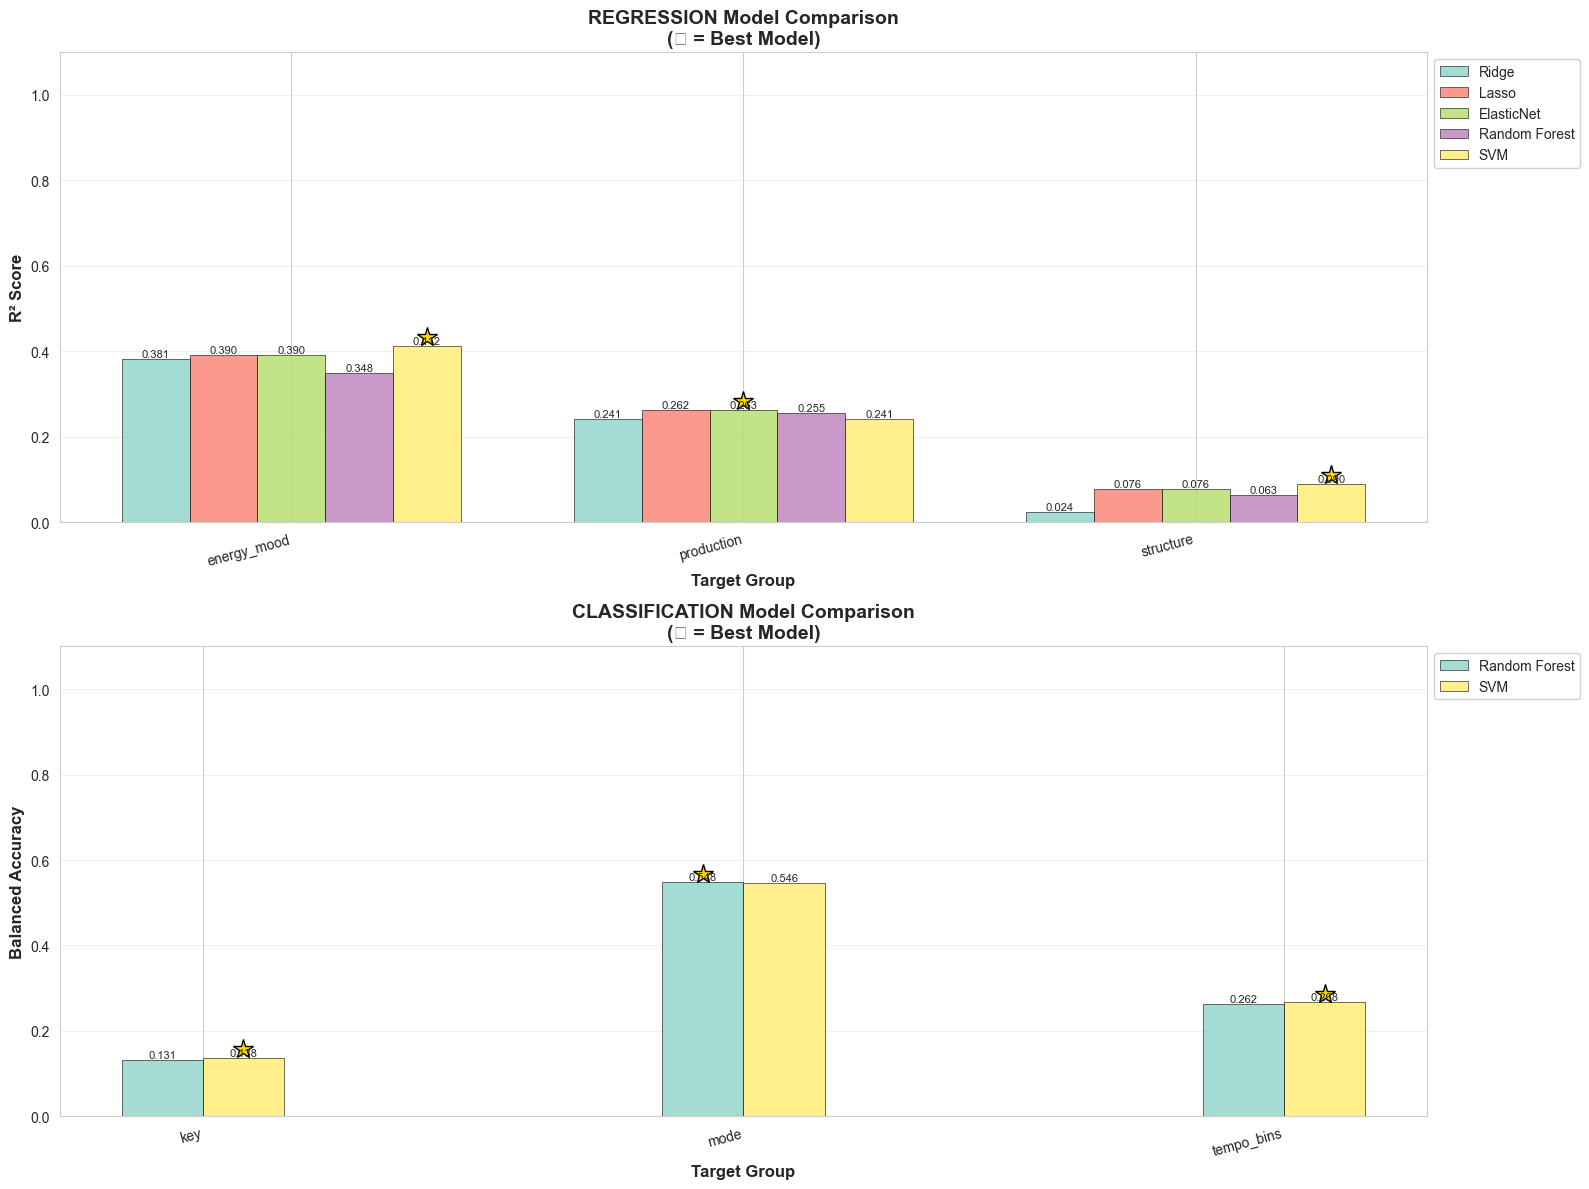

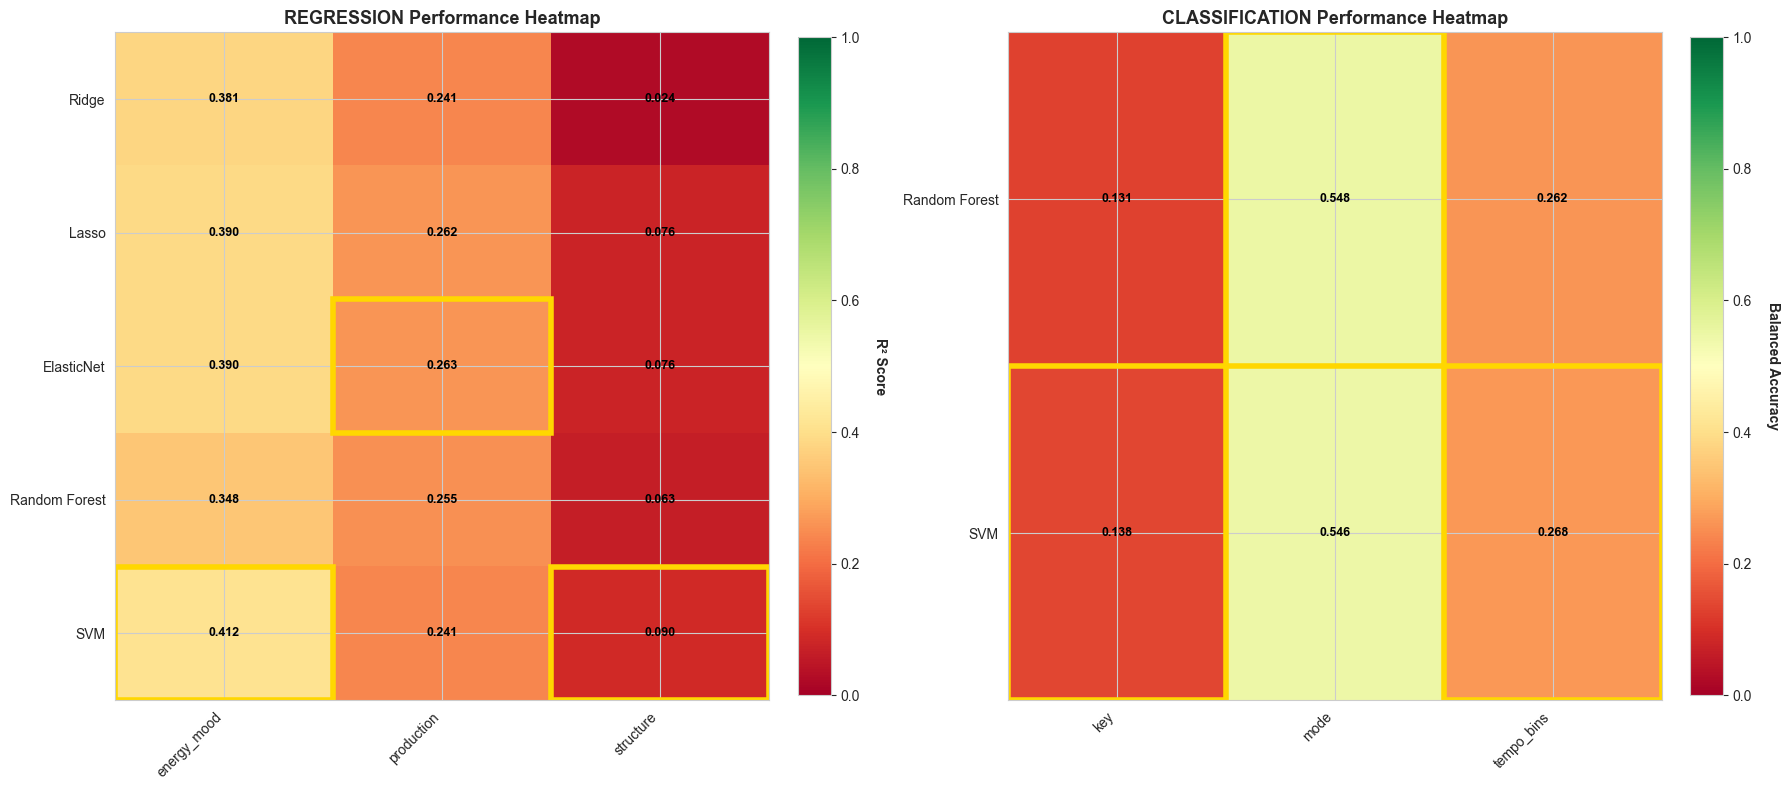

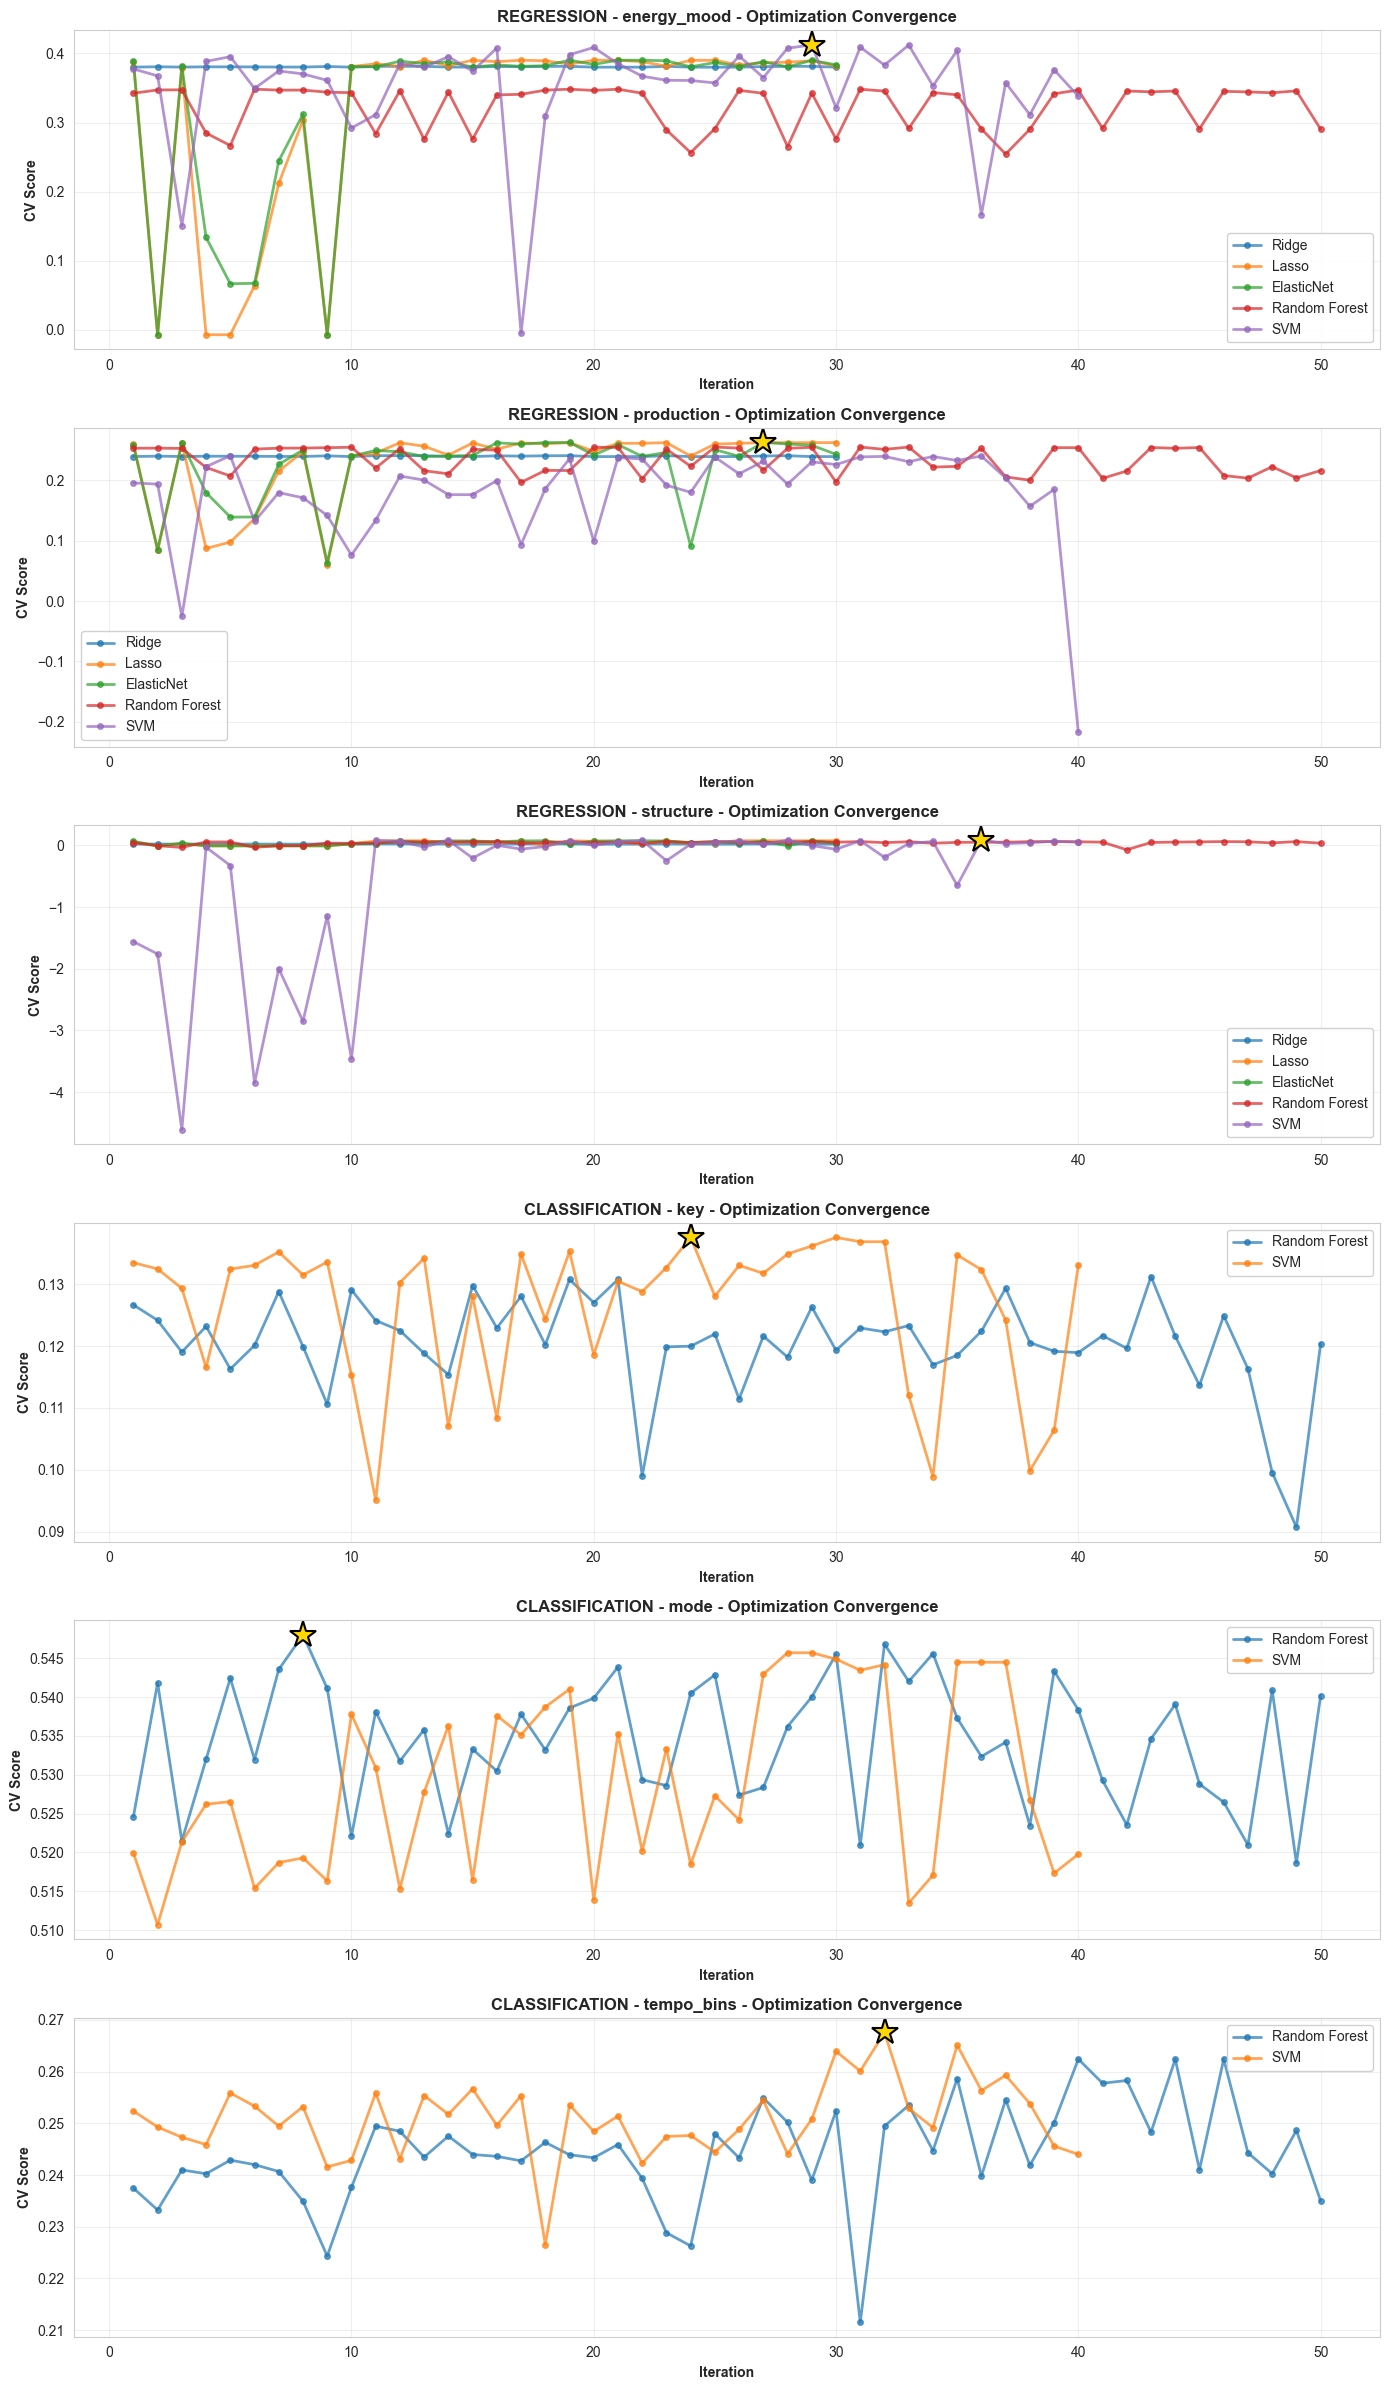

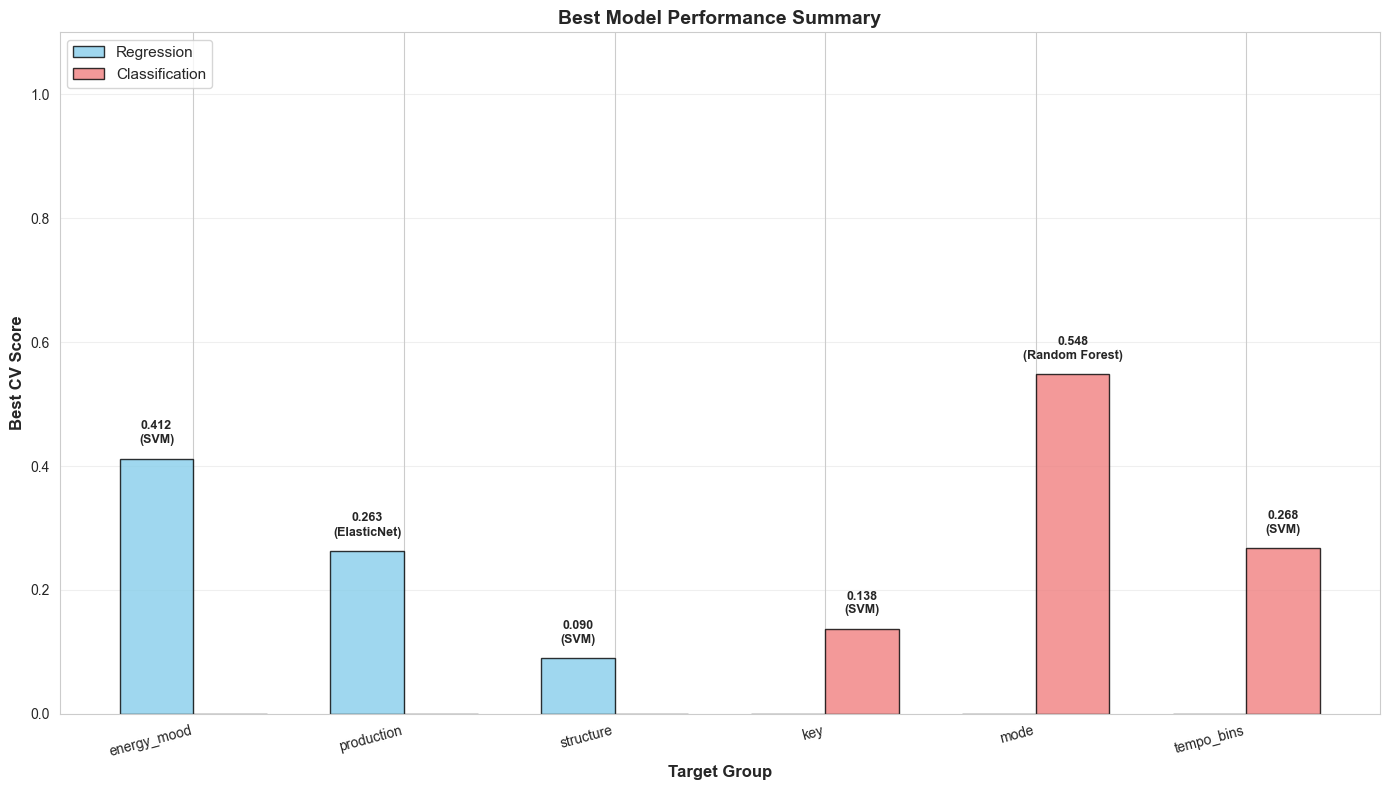

In [ ]:
viz_dir_pca = prc / "visualizations" / "pca_features"
viz_dir_pca.mkdir(parents=True, exist_ok=True)

print("\nGenerating visualizations for PCA features...")
visualizer_pca = ModelVisualizer(pipeline_pca.predictor)

# Check if training results exist
n_groups_pca = sum(len(groups) for groups in visualizer_pca.training_results.values()) if visualizer_pca.training_results else 0

if n_groups_pca > 0:
    print(f"Found {n_groups_pca} training result groups")
    figures_pca = visualizer_pca.plot_all_comparisons(save_dir=viz_dir_pca)
    print(f"Saved comparison plots to {viz_dir_pca}")
else:
    print("Warning: No training results stored. Skipping comparison plots.")

# Predictions vs Actual
print("\nGenerating predictions vs actual plots...")
fig_pred_pca = visualizer_pca.plot_predictions_vs_actual(test_features_pca_df, y_test, n_samples=200)
if fig_pred_pca:
    fig_pred_pca.savefig(viz_dir_pca / "predictions_vs_actual.png", dpi=300, bbox_inches='tight')
    plt.close(fig_pred_pca)
    print(f"Saved: {viz_dir_pca / 'predictions_vs_actual.png'}")

# Confusion Matrices
print("\nGenerating confusion matrices...")
fig_cm_pca = visualizer_pca.plot_confusion_matrices(test_features_pca_df, y_test)
if fig_cm_pca:
    fig_cm_pca.savefig(viz_dir_pca / "confusion_matrices.png", dpi=300, bbox_inches='tight')
    plt.close(fig_cm_pca)
    print(f"Saved: {viz_dir_pca / 'confusion_matrices.png'}")

print("\n" + "="*80)
print("All visualizations saved successfully!")
print(f"Location: {viz_dir_pca}")
print("="*80)

In [4]:
import pandas as pd

# Define the group-level results
results = [
    {"Group": "ENERGY_MOOD", "Targets": ['energy', 'valence', 'danceability'],
     "Task_Type": "Regression", "Best_Model": "SVM", "Score": 0.4122,
     "Params": {'estimator__C': 1.0657845984340375,
                'estimator__epsilon': 0.06508207927956049,
                'estimator__gamma': 0.0027842619799872204}},
    
    {"Group": "PRODUCTION", "Targets": ['loudness', 'acousticness', 'instrumentalness', 'liveness'],
     "Task_Type": "Regression", "Best_Model": "ElasticNet", "Score": 0.2628,
     "Params": {'estimator__alpha': 0.06509865304022165,
                'estimator__l1_ratio': 0.10153594707907124,
                'estimator__selection': 'random'}},
    
    {"Group": "STRUCTURE", "Targets": ['speechiness'],
     "Task_Type": "Regression", "Best_Model": "SVM", "Score": 0.0896,
     "Params": {'C': 60.5214062972065,
                'epsilon': 0.02139333307605589,
                'gamma': 0.00015755396722878573}},
    
    {"Group": "KEY", "Targets": ['key'],
     "Task_Type": "Classification", "Best_Model": "SVM", "Score": 0.1375,
     "Params": {'C': 19.986711327895424,
                'gamma': 0.010446417604534108}},
    
    {"Group": "MODE", "Targets": ['mode'],
     "Task_Type": "Classification", "Best_Model": "Random Forest", "Score": 0.5480,
     "Params": {'bootstrap': False,
                'max_depth': 19,
                'max_features': 'log2',
                'min_samples_leaf': 6,
                'min_samples_split': 5,
                'n_estimators': 160}},
    
    {"Group": "TEMPO_BINS", "Targets": ['tempo_bins'],
     "Task_Type": "Classification", "Best_Model": "SVM", "Score": 0.2676,
     "Params": {'C': 3.0249194238453407,
                'gamma': 0.0068420002336432376}}
]

# Convert to DataFrame
df_groups = pd.DataFrame(results)

# Optional: format target list for readability
df_groups["Targets"] = df_groups["Targets"].apply(lambda t: ", ".join(t))

# Display DataFrame
df_groups


,Group,Targets,Task_Type,Best_Model,Score,Params
0,ENERGY_MOOD,"energy, valence, danceability",Regression,SVM,0.4122,"{'estimator__C': 1.0657845984340375, 'estimato..."
1,PRODUCTION,"loudness, acousticness, instrumentalness, live...",Regression,ElasticNet,0.2628,"{'estimator__alpha': 0.06509865304022165, 'est..."
2,STRUCTURE,speechiness,Regression,SVM,0.0896,"{'C': 60.5214062972065, 'epsilon': 0.021393333..."
3,KEY,key,Classification,SVM,0.1375,"{'C': 19.986711327895424, 'gamma': 0.010446417..."
4,MODE,mode,Classification,Random Forest,0.5480,"{'bootstrap': False, 'max_depth': 19, 'max_fea..."
5,TEMPO_BINS,tempo_bins,Classification,SVM,0.2676,"{'C': 3.0249194238453407, 'gamma': 0.006842000..."


In [ ]:
import pandas as pd

# Same results as before
results = [
    # ENERGY_MOOD (Regression)
    {"Group": "ENERGY_MOOD", "Task_Type": "Regression", "Model": "Ridge", "Score": 0.3813,
     "Params": {'estimator__alpha': 10.0, 'estimator__solver': 'saga'}},
    {"Group": "ENERGY_MOOD", "Task_Type": "Regression", "Model": "Lasso", "Score": 0.3901,
     "Params": {'estimator__alpha': 0.002607561775704386, 'estimator__selection': 'cyclic'}},
    {"Group": "ENERGY_MOOD", "Task_Type": "Regression", "Model": "ElasticNet", "Score": 0.3901,
     "Params": {'estimator__alpha': 0.005426972348943854,
                'estimator__l1_ratio': 0.45299488547151556,
                'estimator__selection': 'cyclic'}},
    {"Group": "ENERGY_MOOD", "Task_Type": "Regression", "Model": "Random Forest", "Score": 0.3482,
     "Params": {'estimator__max_depth': 17, 'estimator__max_features': None,
                'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 3,
                'estimator__n_estimators': 310}},
    {"Group": "ENERGY_MOOD", "Task_Type": "Regression", "Model": "SVM", "Score": 0.4122,
     "Params": {'estimator__C': 1.0657845984340375, 'estimator__epsilon': 0.06508207927956049,
                'estimator__gamma': 0.0027842619799872204}},

    # PRODUCTION (Regression)
    {"Group": "PRODUCTION", "Task_Type": "Regression", "Model": "Ridge", "Score": 0.2409,
     "Params": {'estimator__alpha': 10.0, 'estimator__solver': 'saga'}},
    {"Group": "PRODUCTION", "Task_Type": "Regression", "Model": "Lasso", "Score": 0.2624,
     "Params": {'estimator__alpha': 0.006538099964110018, 'estimator__selection': 'cyclic'}},
    {"Group": "PRODUCTION", "Task_Type": "Regression", "Model": "ElasticNet", "Score": 0.2628,
     "Params": {'estimator__alpha': 0.06509865304022165, 'estimator__l1_ratio': 0.10153594707907124,
                'estimator__selection': 'random'}},
    {"Group": "PRODUCTION", "Task_Type": "Regression", "Model": "Random Forest", "Score": 0.2552,
     "Params": {'estimator__max_depth': 10, 'estimator__max_features': None,
                'estimator__min_samples_leaf': 7, 'estimator__min_samples_split': 2,
                'estimator__n_estimators': 350}},
    {"Group": "PRODUCTION", "Task_Type": "Regression", "Model": "SVM", "Score": 0.2408,
     "Params": {'estimator__C': 25.041499136197736, 'estimator__epsilon': 0.09322554542377544,
                'estimator__gamma': 0.0003800674800490907}},

    # STRUCTURE (Regression)
    {"Group": "STRUCTURE", "Task_Type": "Regression", "Model": "Ridge", "Score": 0.0241,
     "Params": {'alpha': 10.0, 'solver': 'saga'}},
    {"Group": "STRUCTURE", "Task_Type": "Regression", "Model": "Lasso", "Score": 0.0765,
     "Params": {'alpha': 0.00210516474477174, 'selection': 'cyclic'}},
    {"Group": "STRUCTURE", "Task_Type": "Regression", "Model": "ElasticNet", "Score": 0.0765,
     "Params": {'alpha': 0.004223670326836847, 'l1_ratio': 0.4822498536923371,
                'selection': 'random'}},
    {"Group": "STRUCTURE", "Task_Type": "Regression", "Model": "Random Forest", "Score": 0.0630,
     "Params": {'max_depth': 18, 'max_features': 'sqrt',
                'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 150}},
    {"Group": "STRUCTURE", "Task_Type": "Regression", "Model": "SVM", "Score": 0.0896,
     "Params": {'C': 60.5214062972065, 'epsilon': 0.02139333307605589,
                'gamma': 0.00015755396722878573}},

    # KEY (Classification)
    {"Group": "KEY", "Task_Type": "Classification", "Model": "Random Forest", "Score": 0.1312,
     "Params": {'bootstrap': True, 'max_depth': 8, 'max_features': 'log2',
                'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 337}},
    {"Group": "KEY", "Task_Type": "Classification", "Model": "SVM", "Score": 0.1375,
     "Params": {'C': 19.986711327895424, 'gamma': 0.010446417604534108}},

    # MODE (Classification)
    {"Group": "MODE", "Task_Type": "Classification", "Model": "Random Forest", "Score": 0.5480,
     "Params": {'bootstrap': False, 'max_depth': 19, 'max_features': 'log2',
                'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 160}},
    {"Group": "MODE", "Task_Type": "Classification", "Model": "SVM", "Score": 0.5457,
     "Params": {'C': 1.504264775088212, 'gamma': 0.001}},

    # TEMPO_BINS (Classification)
    {"Group": "TEMPO_BINS", "Task_Type": "Classification", "Model": "Random Forest", "Score": 0.2624,
     "Params": {'bootstrap': True, 'max_depth': 11, 'max_features': None,
                'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 350}},
    {"Group": "TEMPO_BINS", "Task_Type": "Classification", "Model": "SVM", "Score": 0.2676,
     "Params": {'C': 3.0249194238453407, 'gamma': 0.0068420002336432376}},
]

# Convert to DataFrame
df_all_models = pd.DataFrame(results)

# Add a column combining model, score, and params into a dictionary
df_all_models["Summary"] = df_all_models.apply(
    lambda row: {"Model": row["Model"], "Score": row["Score"], "Params": row["Params"]}, axis=1
)


df_all_models_final = df_all_models[["Group", "Task_Type", "Summary"]]
df_all_models_final


,Group,Task_Type,Summary
0,ENERGY_MOOD,Regression,"{'Model': 'Ridge', 'Score': 0.3813, 'Params': ..."
1,ENERGY_MOOD,Regression,"{'Model': 'Lasso', 'Score': 0.3901, 'Params': ..."
2,ENERGY_MOOD,Regression,"{'Model': 'ElasticNet', 'Score': 0.3901, 'Para..."
3,ENERGY_MOOD,Regression,"{'Model': 'Random Forest', 'Score': 0.3482, 'P..."
4,ENERGY_MOOD,Regression,"{'Model': 'SVM', 'Score': 0.4122, 'Params': {'..."
5,PRODUCTION,Regression,"{'Model': 'Ridge', 'Score': 0.2409, 'Params': ..."
6,PRODUCTION,Regression,"{'Model': 'Lasso', 'Score': 0.2624, 'Params': ..."
7,PRODUCTION,Regression,"{'Model': 'ElasticNet', 'Score': 0.2628, 'Para..."
8,PRODUCTION,Regression,"{'Model': 'Random Forest', 'Score': 0.2552, 'P..."
9,PRODUCTION,Regression,"{'Model': 'SVM', 'Score': 0.2408, 'Params': {'..."


In [13]:
df_all_models_final.to_csv(root / prc / "models_summary.csv", index=False)